## Testing DataFrames

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import seaborn as sn
from datetime import datetime
from IPython.display import HTML

## Helper Functions:
### Get Formated Datetime from Timestamp

In [193]:
def get_datetime_str_from_timestamp(tstimestamp,datatime_szformat='%Y-%m-%d'):
    """ 
    Convers a python Timestamp valiable into a string formatted per the provided
    szformat string
    format can be found at https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
    """
    
    return datetime.strftime(tstimestamp, datatime_szformat)

### Get Yahoo Finance Stock Price History

In [194]:
def get_yf_price_history(symbol, period=None,interval='1d',start_date=None,end_date=None):
    """ 
    Calls Yahoo Finance Ticker() function to retrieve stock historical prices 
    and returns a DataFrame
    """
    return yf.Ticker(symbol).history(interval=interval,period=period, start=start_date, end=end_date)

### Get Period Performace DataFrame 

In [195]:
def get_performance_df(df_list,period_start,period_end):
    """ 
    Takes a list of DataFrames of pre-calculated % Change price data
    and creates a Performance DataFrame over the period provided 
    """
    
    perf_df = pd.DataFrame(columns=['Stocks','% Price Change']) 
    i = 0
    for s in df_list.keys():
        perf_df.loc[i] = [s,np.round(df_list[s].iloc[-1],2)]
        i+=1

    perf_df.set_index('Stocks',drop=True,inplace=True)
    #display(perf_df)
    return perf_df

### Download and Compare Changes in Stock Prices

In [196]:
def plot_price_change_comp(stock_list,start_date,end_date,interval):
    """
    Plot multiple stocks price %changes on one chart and returns
    a list of Dataframes for each stock symbob in stock_list 
    """
    
    main_df = {}
    for s in stock_list:
        #main_df[s] = yf.Ticker(s).history(interval=interval, start=start_date, end=end_date)['Close'].pct_change(periods=1).dropna().cumsum() * 100
        main_df[s] = get_yf_price_history(symbol=s,interval=interval,start_date=start_date,end_date=end_date)['Close'].pct_change(periods=1).dropna().cumsum() * 100

    ax = ''
    for k in main_df.keys():
        if ax == '':
            ax = main_df[k].plot(figsize=(16,8),linewidth=3)    
        else:
            main_df[k].plot(ax=ax,linewidth=3)

    ax.set_title('Relative Perfomance: % Change of Stock Prices')
    ax.title.set_size(20)

    ax.set_xlabel("Time")
    ax.set_ylabel("% Price Change")

    ax.grid(True)
    ax.legend(main_df.keys())

    plt.show()
    return main_df


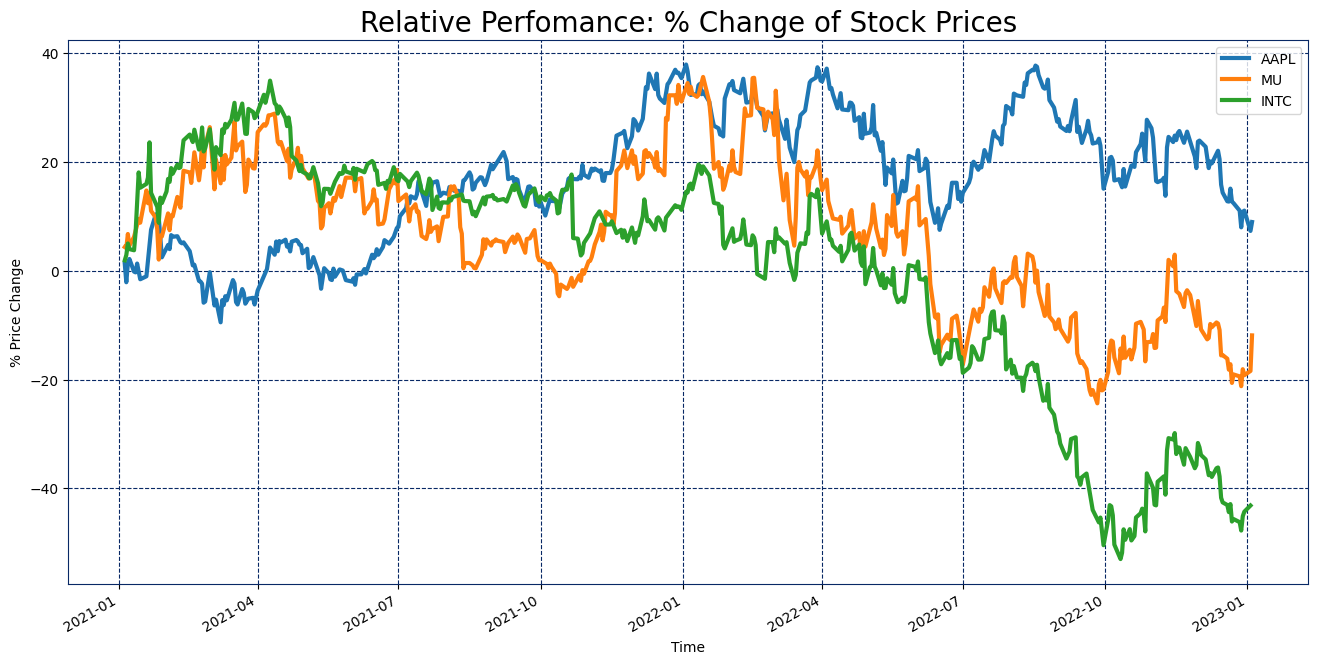

,% Price Change
Stocks,
AAPL,8.94
MU,-11.90
INTC,-43.15


In [199]:

stock_list = ['AAPL','MU','INTC']
start_date = '2021-01-03'
end_date = datetime.now()
interval = '1d'

if(perf_def):
    del perf_def

main_df = plot_price_change_comp(stock_list,start_date,end_date,interval)
perf_df = get_performance_df(df_list=main_df,period_start=start_date,period_end=end_date)
display(perf_df)

In [198]:
def check_sma(price_history: object, SMA_lookback_in_dayes: int) -> float:
    
    df_price_history = pd.DataFrame(price_history)
    # Calculate the stock's SMA
    sma = df_price_history['Close'].rolling(window=SMA_lookback_in_dayes).mean().dropna()
    #print(sma)
    # Calculate the change in the SMA over the specified period
    sma_change = sma.iloc[-1] - sma.iloc[-1*SMA_lookback_in_dayes]
    
    return sma.iloc[-1], sma_change

symb = "AAPL"

testdf = yf.Ticker(symb).history(interval=interval, start=start_date, end=end_date)['Close']

sma_periods= [20,50,200]
date_format = "%A %m-%d-%Y %I:%M%p"

#last_date_str = datetime.strftime(testdf.index[-1], date_format)
last_date_str = get_datetime_str_from_timestamp(testdf.index[-1],date_format)

print(symb,"Price EOD on",last_date_str," = $",np.round(testdf.iloc[-1],2))
for i in sma_periods:
    sma, sma_change = check_sma(testdf, i)
    print("-- SMA(",i,") = ",np.round(sma,2),". The % Change in last ",i,"days is ",sma_change)

print("Done!")

AAPL Price EOD on Tuesday 01-03-2023 12:00AM  = $ 125.07
-- SMA( 20 ) =  136.22 . The % Change in last  20 days is  -10.40799789428712
-- SMA( 50 ) =  142.66 . The % Change in last  50 days is  -11.191429138183594


IndexError: single positional indexer is out-of-bounds

In [ ]:
import matplotlib.dates as mpl_dates
import mplfinance as mpf

symbol='^GSPC'
interval = '1wk'

start_date = '2020-01-01'
end_date ='2022-12-31'

# Extracting Data for plotting
data = yf.Ticker(symbol).history(interval=interval,start=start_date, end=end_date)
data.index.name = 'Date'
kwargs={'warn_too_much_data':10000}
mpf.plot(data,figsize=(18,10),type='candle',volume=True,**kwargs,style='sas',title=symbol+" Stock")
